# Simple Bottom Up Casing Design - Part 3

Created by Lukas Mosser, 2016

## Introduction
We will look at how we can use python and related libraries to estimate casing setting depth.

We will not deal with the theory behind casing seat determination but only give a quick outline of the bottom up approach.
We assume here that our pore pressure curves are simple monotonic increasing or decreasing functions. In simple terms,
we don't encounter any abnormal pressure zones or "bumps" in our pore pressure or frac gradient. Of course, in reality this is not always the case and we may want to consider these zones.

What you will learn from this:

1. 1D-Interpolation using **numpy.interp** library

## Computational approach (Part 1: simplified)

1. We start at the highest value of pore pressure at our target depth.
2. Extend a vertical line. Where we intersect the fracture gradient, this depth is where a casing is placed.
3. Find the pore pressure at the casing seat depth.
4. Have you reached the surface? No, go back to 1. Yes, great we're done.

As you may have noticed we will move between 1. and 4. until we have determined all casing seats and arrive at the surface.
This method will be similar for when we account for abnormal pressures, but we will have to deal with the "bumps".

Let's load some data and have a look at it:

In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.signal import argrelmax

In [11]:
fracture_pressure_data = np.loadtxt("data/fracture_pressure_abnormal.csv", delimiter=",")
fracture_pressure, TVD_frac = fracture_pressure_data.T

pore_pressure_data = np.loadtxt("data/pore_pressure_abnormal.csv", delimiter=",")
pore_pressure, TVD_pore = pore_pressure_data.T

print argrelmax(pore_pressure)[0]
print pore_pressure[argrelmax(pore_pressure)[0]]

[9]
[ 11.89304653]


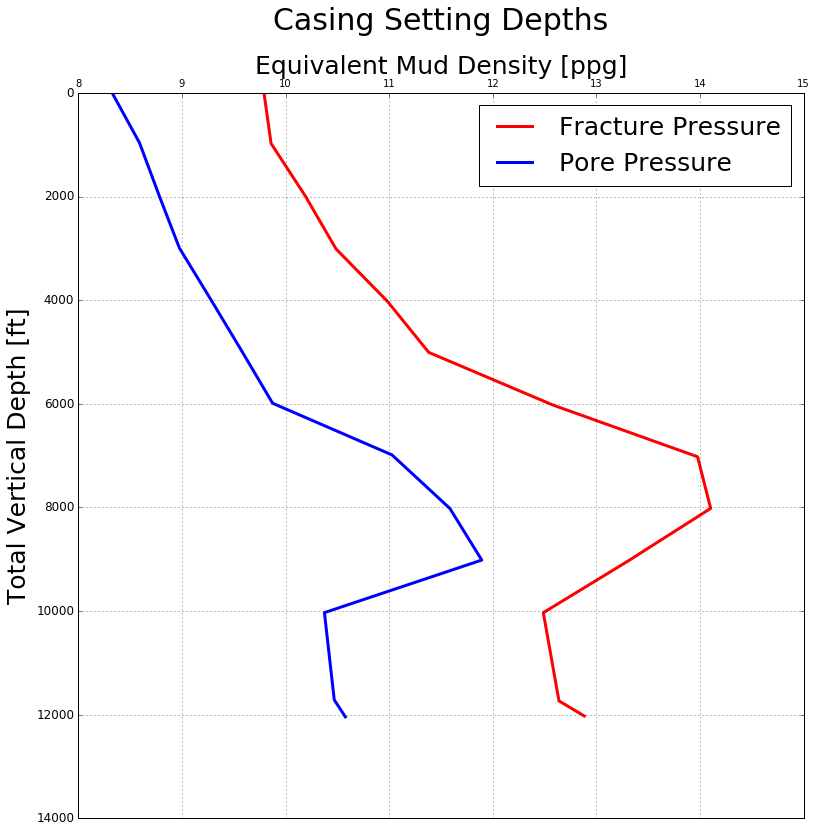

In [7]:
fig, ax = plt.subplots(1, figsize=(13, 13))

ax.set_title("Casing Setting Depths", fontsize=30, y=1.08)

label_size = 12

ax.plot(fracture_pressure, TVD_frac, color="red", linewidth=3, label="Fracture Pressure")
ax.plot(pore_pressure, TVD_pore, color="blue", linewidth=3, label="Pore Pressure")


ax.set_ylabel("Total Vertical Depth [ft]", fontsize=25)
ax.set_ylim(ax.get_ylim()[::-1])

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
ax.set_xlabel("Equivalent Mud Density [ppg]", fontsize=25)
ax.ticklabel_format(fontsize=25)
ax.grid()
ax.legend(fontsize=25)

## Turning theory into code

We now want to turn our list of steps into a piece of working code let's start with a naive approach.

We will use **numpy.interp** to compute linear interpolated values from our datasets.
This function takes a list of x values where we want to interpolate (We can compute many at once! Neat!), as well as the x and y values of the data we want to interpolate from. In our case the pore and fracture pressure data.

Since we use a bottom up approach, we know that at the bottom casing setting depth is governed by the pore pressure at the target depth. This is easily found in python by performing list_name[-1] on any list! (Ignore significant digits, you know the drill!)

In [12]:
class BottomUpCasingDesign(object):
    def __init__(self, fracture_pressure, tvd_frac, pore_pressure, tvd_pore):
        self.fracture_pressure = fracture_pressure
        self.tvd_frac = tvd_frac
        
        self.pore_pressure = pore_pressure
        self.tvd_pore = tvd_pore
        
    def bottom_up_casing_seat(self, previous_section_mud_weight):
        next_section_tvd = np.interp(previous_section_mud_weight, self.fracture_pressure, self.tvd_frac)
        next_section_mud_weight = np.interp(next_section_tvd, self.tvd_pore, self.pore_pressure)
        return next_section_mud_weight, next_section_tvd
    
    
    def find_casing_seats(self, maxiter=100):
        current_mud_weight = self.pore_pressure[-1]
        current_depth = self.tvd_pore[-1]
        
        casing_seats = []
        i = 0
        while current_depth > 0.0 and i < maxiter:
            print self.check_self_intersect(current_mud_weight, self.tvd_pore, self.pore_pressure)
            next_section_mud_weight, next_section_tvd = self.bottom_up_casing_seat(current_mud_weight)
            casing_seats.append((next_section_tvd, next_section_mud_weight))
            
            current_depth, current_mud_weight = next_section_tvd, next_section_mud_weight
            i += 1
            break
        return casing_seats
    
    def check_self_intersect(self, value, tvd, mudweight):
        self_intersect_tvd = np.interp(value, mudweight, tvd)
        return self_intersect_tvd
    
    def get_casing_seat_plot_data(self, casing_seats):
        casing_seats_tvd = [self.tvd_pore[-1], casing_seats[0][0]]
        casing_seats_ppg = [self.pore_pressure[-1], self.pore_pressure[-1]]
        
        for p1, p2 in zip(casing_seats, casing_seats[1::]):
            casing_seats_tvd.append(p1[0])
            casing_seats_tvd.append(p2[0])

        for p1, p2 in zip(casing_seats, casing_seats):
            casing_seats_ppg.append(p1[1])
            casing_seats_ppg.append(p2[1])
        return casing_seats_tvd, casing_seats_ppg[0:-2]

In [13]:
fracture_pressure_safety = 0.97*fracture_pressure
pore_pressure_safety = 1.03*pore_pressure
    
bottom_up = BottomUpCasingDesign(fracture_pressure_safety, TVD_frac, pore_pressure_safety, TVD_pore)

casing_seats = bottom_up.find_casing_seats()
casing_seats_tvd, casing_seats_ppg = bottom_up.get_casing_seat_plot_data(casing_seats)
print casing_seats_tvd
print casing_seats_ppg

6596.96770716
[12041.462260339593, 4635.437968681077]
[10.893760229935475, 10.893760229935475]


Step two now involves extending a line up until we hit the fracture pressure. This means we have to interpolate our known pore pressure at target to find the corresponding depth in our fracture pressure data.
Numpy lets us perform this task in one simple line of code.

We've hit the surface! Therefore, no more casing seats and we are done.
Let's plot the results!

We will use **matplotlib** to perform any plotting tasks.

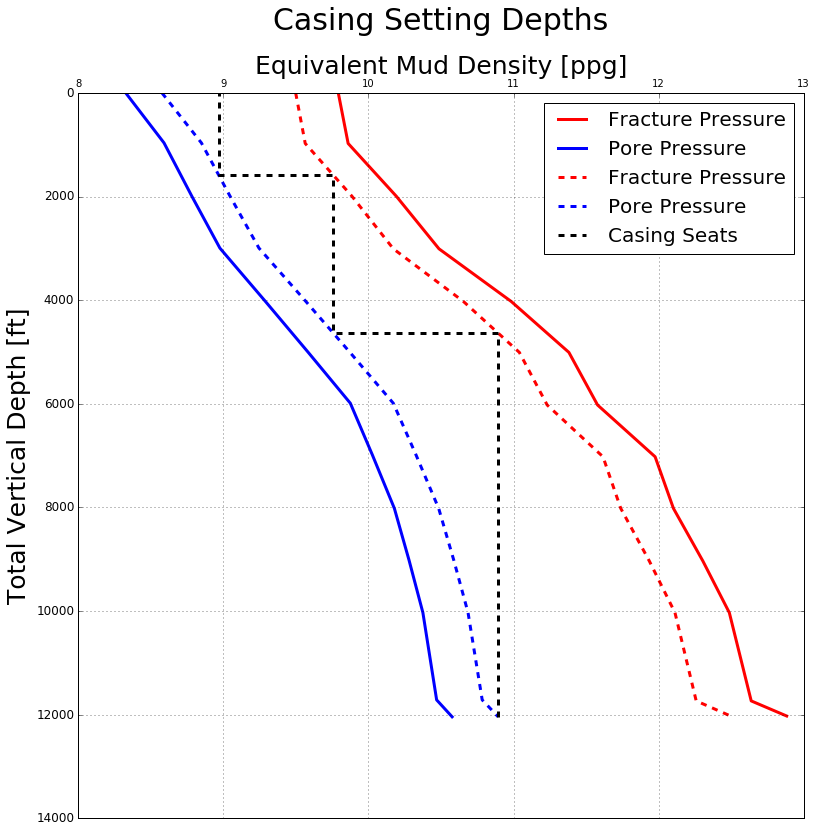

In [73]:
fig, ax = plt.subplots(1, figsize=(13, 13))

ax.set_title("Casing Setting Depths", fontsize=30, y=1.08)

label_size = 12

ax.plot(fracture_pressure, TVD_frac, color="red", linewidth=3, label="Fracture Pressure")
ax.plot(pore_pressure, TVD_pore, color="blue", linewidth=3, label="Pore Pressure")

ax.plot(fracture_pressure_safety, TVD_frac, color="red", linewidth=3, label="Fracture Pressure", linestyle="--")
ax.plot(pore_pressure_safety, TVD_pore, color="blue", linewidth=3, label="Pore Pressure", linestyle="--")


ax.plot(casing_seats_ppg, casing_seats_tvd, color="black", linestyle="--", linewidth=3, label="Casing Seats")

ax.set_ylabel("Total Vertical Depth [ft]", fontsize=25)
ax.set_ylim(ax.get_ylim()[::-1])

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

yed = [tick.label.set_fontsize(label_size) for tick in ax.yaxis.get_major_ticks()]
xed = [tick.label.set_fontsize(label_size) for tick in ax.xaxis.get_major_ticks()]
ax.set_xlabel("Equivalent Mud Density [ppg]", fontsize=25)
ax.ticklabel_format(fontsize=25)
ax.grid()
ax.legend(fontsize=20)

This concludes part 1 of our casing setting depth determination notebook. Next time we will automate, this by using recursive functions. Our third part will deal with abnormal pressure zones and finally we will finish by integrating microsoft excel data sources. Until next time!